# Comparison of clustering algorithms on artificial datasets

These examples demonstrate the properties of various clustering algorithms on data sets, which structure is "interesting" in terms of the possibility of correct separation into clusters, but only two-dimensional. For each algorithm on each data set parameters were selected that provide good results. We will discuss how to choose such parameters in another notebook.

The code presented in this notebook is a modification of an example from sklearn: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

In [2]:
import time # needed to measure execution time
import warnings

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To begin with, let us generate 6 sets of two-dimensional data of a special kind with cluster labels.

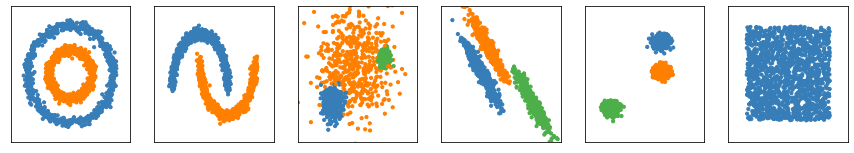

In [4]:
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler
np.random.seed(0)

n_samples = 1500
noisy_circles = make_circles(n_samples=n_samples, factor=.5, # two circles with noise
                                      noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05) # two "moons" with noise
blobs = make_blobs(n_samples=n_samples, random_state=8) # three similar round blobs
no_structure = (np.random.rand(n_samples, 2), np.array([0]*n_samples)) # random point without any structure

# three eliptical blobs
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# three blobs with different variance
varied = make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 4, 0.5],
                             random_state=random_state)

datasets = [noisy_circles, noisy_moons, varied, aniso, blobs, no_structure]

colors = np.array(['#377eb8', '#ff7f00', '#4daf4a'])

# draw these datasets on axes
plt.figure(figsize=(6*2 + 3, 2.5))
for i, ds in enumerate(datasets):
    X, y = ds
    X = StandardScaler().fit_transform(X) # standardize data
    plt.subplot(1, len(datasets), i+1)
    plt.scatter(X[:, 0], X[:, 1], c=colors[y], s=10)

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

Set parameters for clustering algorithms.

In [3]:
# default parameters for all algorithms
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

# specification of some parameters for each data set
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

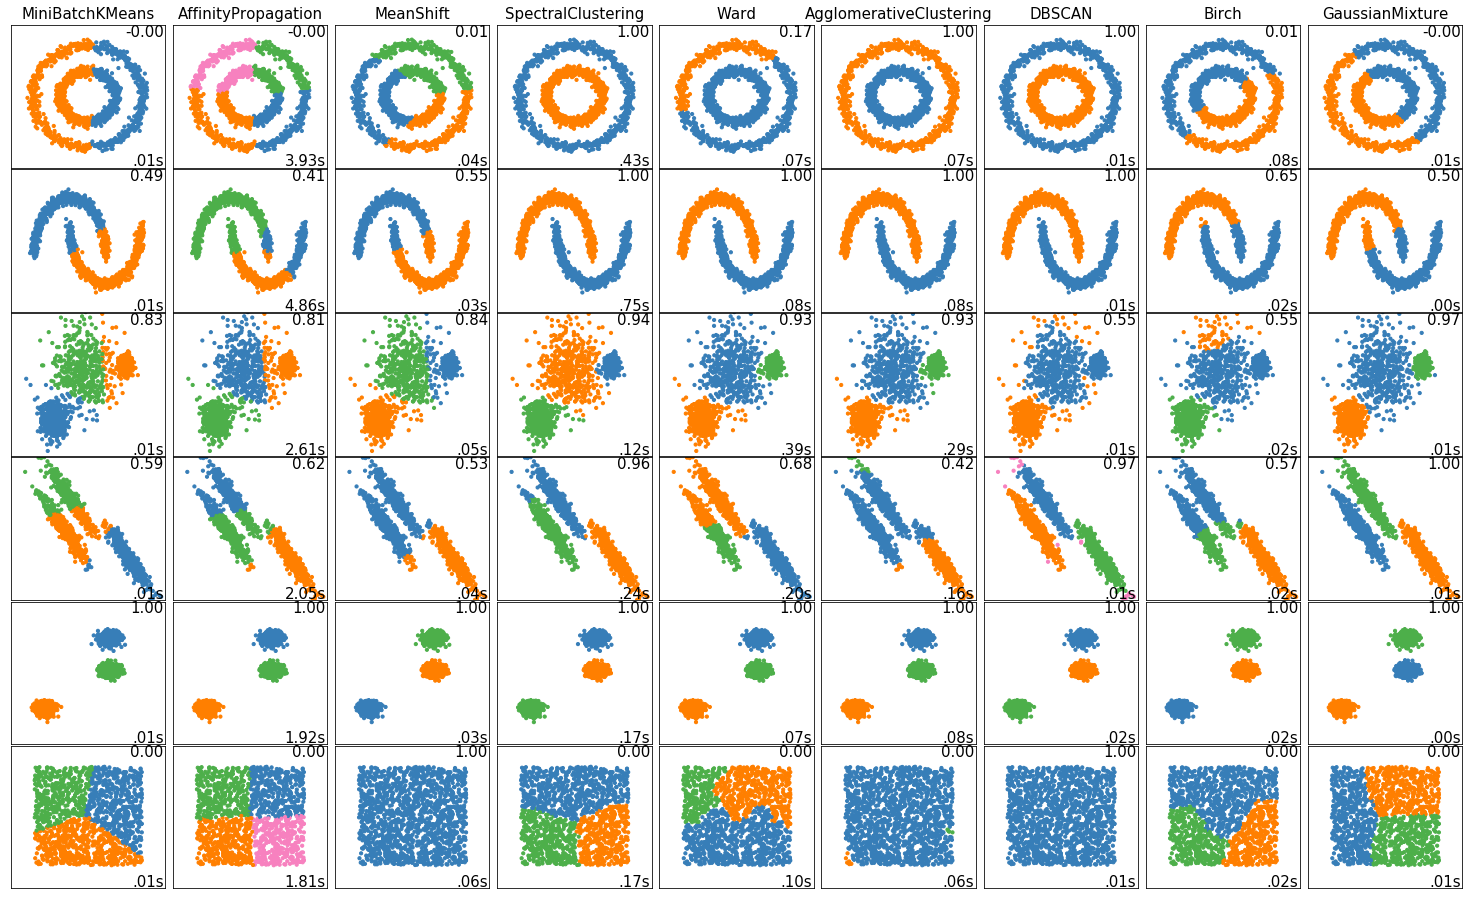

In [4]:
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
from sklearn.metrics import adjusted_rand_score

# display the clustring results as a set of graphs
# (number of data sets * number of algorithms to compare)
plt.figure(figsize=(9 * 2 + 3, 12.5)) # set image size
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01) # set paddings and indents
plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    
    params = default_base.copy()
    params.update(algo_params) # change the basic parameters, if the specification requires it

    X, y = dataset
    
    X = StandardScaler().fit_transform(X) # standardize data
    
    # estimate bandwidth for Mean Shift algorithm
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # build a weighted connectivity matrix for points; it is required by Agl. Clust.
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # n_neighbors - number of nearest neightbours
    # make the matrix symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Create cluster objects
    
    # Mean Shift with bandwith estimated above
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    
    # K-means with training on small subsamples at every step
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    
    # Agglomerative Clustering with minimization of dispersion within clusters
    # input the connectivity matrix as well
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    
    # Nearest-neighbor Spectral Clustering
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    
    # DBSCAN
    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    # Afinity propagation
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    
    # Agglomerative clustering minimizing mean distance between a pair of points in a cluster
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    
    # Birch
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    
    # Gaussian mixture model decomposition
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    # create a dictionary with algorithm names as keys
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    # iterate over all the algorithms
    for name, algorithm in clustering_algorithms:
        t0 = time.time() # record the beginning of execution

        # keep track of warnings due to graph connectivity issues
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X) # fit current algorithm

        t1 = time.time() # record the end of execution
        if hasattr(algorithm, 'labels_'): # if the object has an attribute labels_ - assigned labels of the cluster
            y_pred = algorithm.labels_.astype(np.int) # treat them as predictions
        else:
            y_pred = algorithm.predict(X) # else predict labels

        
        # select current subplot
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        if i_dataset == 0: # put algorithm names over the graphs in the first row
            plt.title(name, size=15)
        
        # set color schemes
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right') # put execution time in the right bottom corner
        
        plt.text(.99, .92, ('%.2f' % adjusted_rand_score(y, y_pred)),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right') # put adjusted_rand_index in the right top corner
        plot_num += 1

plt.show()